In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.sys.path.append('../../evaluation/')
import pickle
import numpy as np
import pandas as pd
import methods
import metrics
import tensorflow as tf
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

data_path = '../../data/simulated_2d/test/'
model_path = './model/'
gmm_path = './predictions_gmm.pkl'


In [2]:
# load data
data = pickle.load(open(data_path+'/input_data.pkl', 'rb'))
targets = pickle.load(open(data_path+'/target_data.pkl', 'rb'))
targets = [
    metrics.output_to_stats_2d(i) for i in targets
]

In [3]:
# predict GMM

if os.path.exists(gmm_path):
    p_gmm = pickle.load(open(gmm_path, 'rb'))
else:
    p_gmm = []
    for c,i in enumerate(data):
        if c%200==0:
            print(c)
        p = methods.predict_gmm(i)
        p_gmm.append([p['mean'], p['covariance']])

    with open(gmm_path, 'wb') as f:
        pickle.dump(p_gmm, f)
        
# compute error
errors_gmm = metrics.get_errors(targets, p_gmm)


In [9]:
# predict NN

os.sys.path.append('../training/')
os.sys.path.append(model_path)
from predict import extract_features

# load model
model = tf.keras.models.load_model(model_path+'/model_checkpoint')
scalery = pickle.load(open(model_path+'/model_y_scaler.pkl', 'rb'))

# extract features
features = np.stack([extract_features(i) for i in data])
features = features[..., np.newaxis]

# predict
p_nn = model.predict(features)
p_nn = scalery.inverse_transform(p_nn) # scale outputs

p_nn_ref_fracs = [i[-1] for i in p_nn]

p_nn = [
    metrics.output_to_stats_2d(i) for i in p_nn
]

# compute error
errors_nn = metrics.get_errors(targets, p_nn)


32/32 [==============================] - 0s 4ms/step


In [5]:
means = pickle.load(open(data_path+'/means.pkl', 'rb'))
stds = pickle.load(open(data_path+'/stds.pkl', 'rb'))
sizes = pickle.load(open(data_path+'/sizes.pkl', 'rb'))
corr_mats = pickle.load(open(data_path+'/corr_mats.pkl', 'rb'))
components = pickle.load(open(data_path+'/components.pkl', 'rb'))


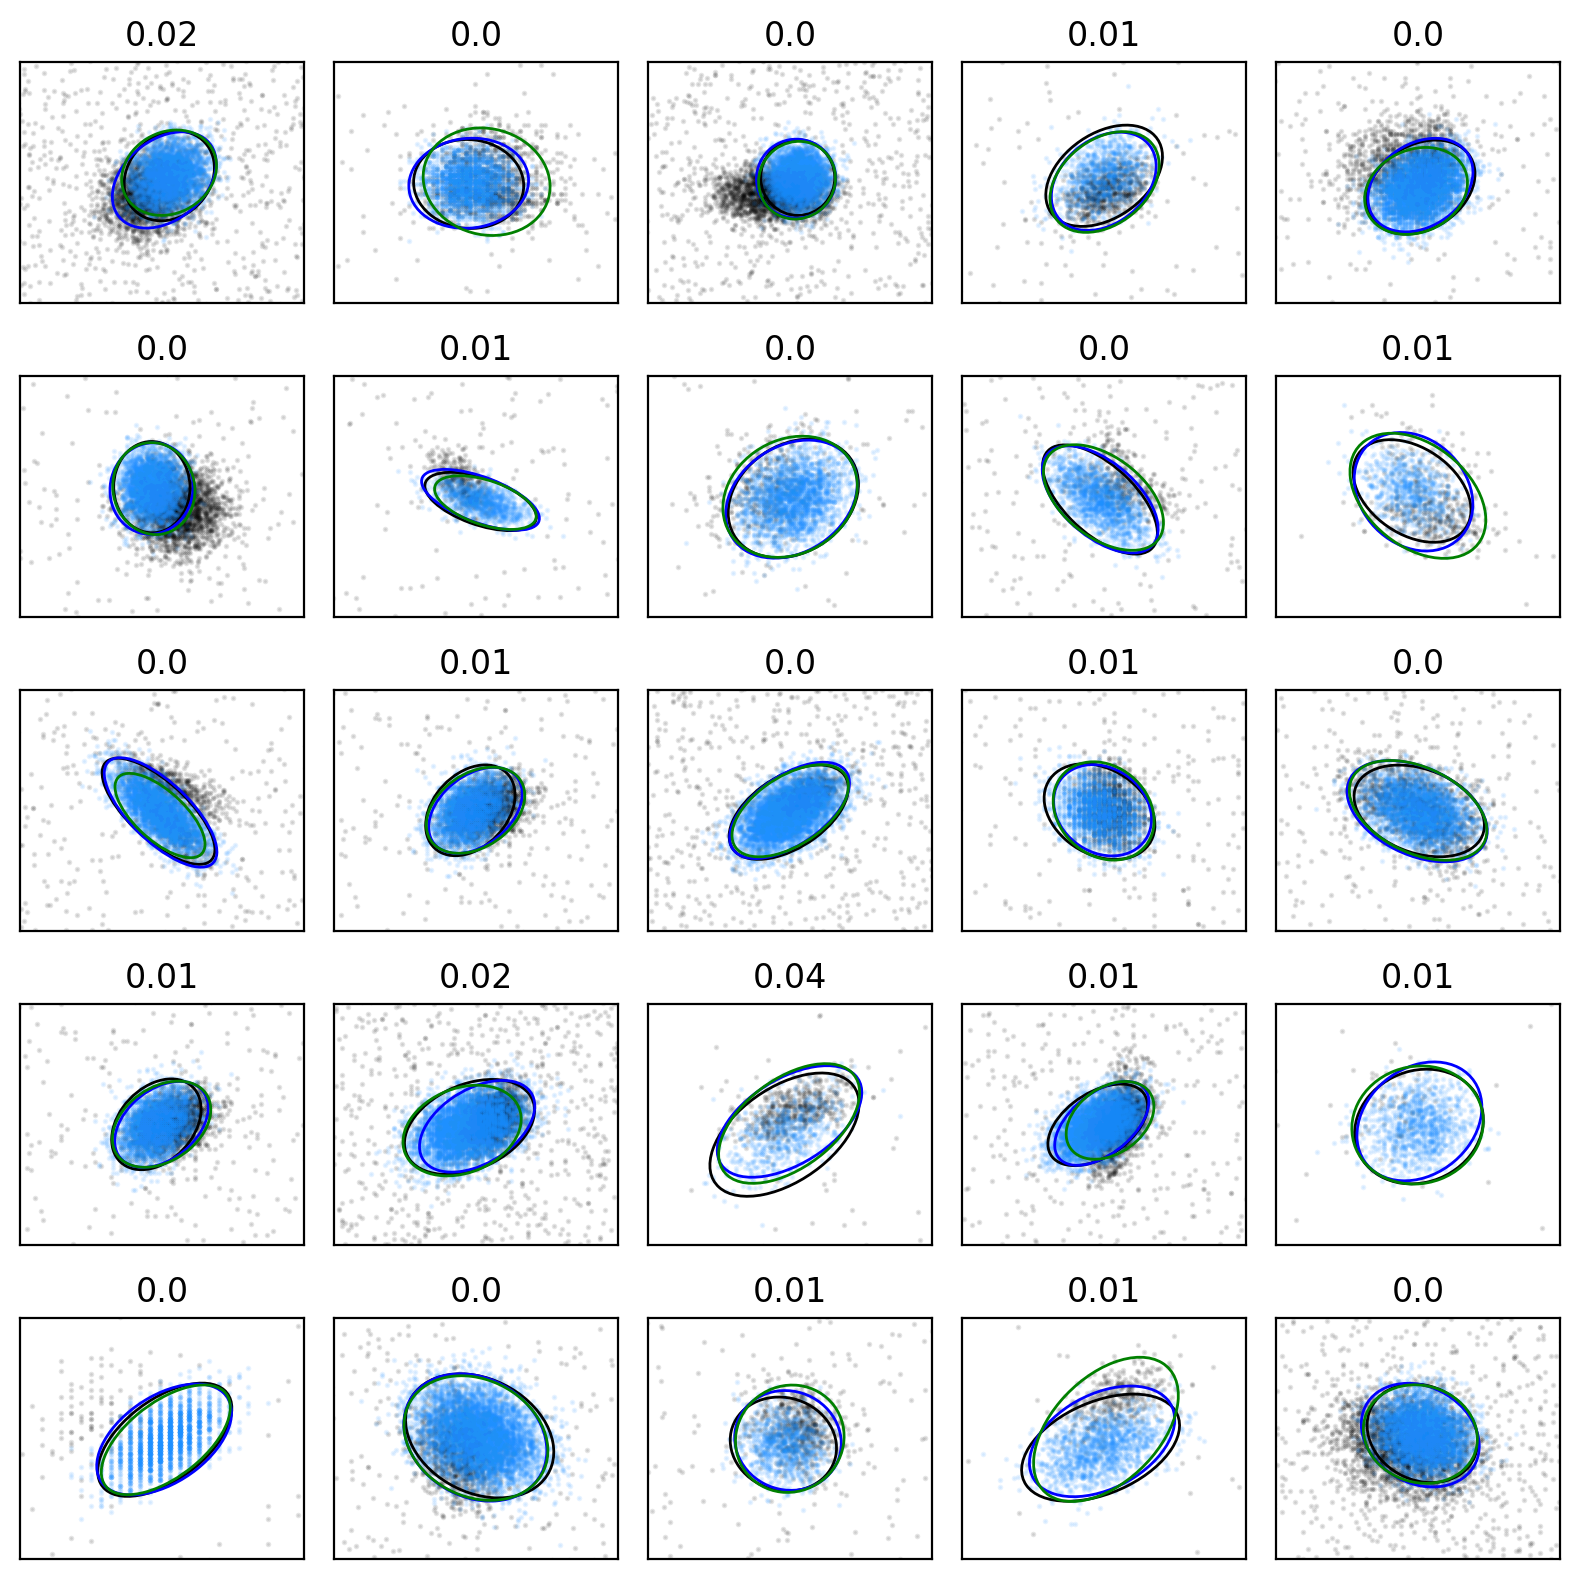

In [6]:
# check examples

predictions = {
    'GMM': p_gmm,
    'NN': p_nn
}

nr = 5
nc = 5

# or random choice
idx = np.random.choice(len(data), nr*nc)

x_range = np.linspace(-4, 4, 41)

plt.figure(figsize=(8,8), dpi=200)

for i in range(nr*nc):
    
    plt.subplot(nr, nc, i+1)
    
    plt.scatter(data[idx[i]][components[idx[i]]!=0,0], data[idx[i]][components[idx[i]]!=0,1], s=1, c='k', alpha=0.1)
    plt.scatter(data[idx[i]][components[idx[i]]==0,0], data[idx[i]][components[idx[i]]==0,1], s=1, c='dodgerblue', alpha=0.1)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    
    # target
    ell = metrics.plot_cov_ellipse(targets[idx[i]][0].squeeze(), targets[idx[i]][1], edgecolor='k', fc='none')
    plt.gca().add_patch(ell)
    
    # nn
    ell = metrics.plot_cov_ellipse(predictions['NN'][idx[i]][0].squeeze(), predictions['NN'][idx[i]][1], edgecolor='b', fc='none')
    plt.gca().add_patch(ell)
    
    # gmm
    ell = metrics.plot_cov_ellipse(predictions['GMM'][idx[i]][0].squeeze(), predictions['GMM'][idx[i]][1], edgecolor='g', fc='none')
    plt.gca().add_patch(ell)
    
#     plt.title(f'{errors_nn[idx[i]]<errors_gmm[idx[i]]}')
    plt.title(f'{round(errors_nn[idx[i]],2)}')
        
plt.tight_layout()
    

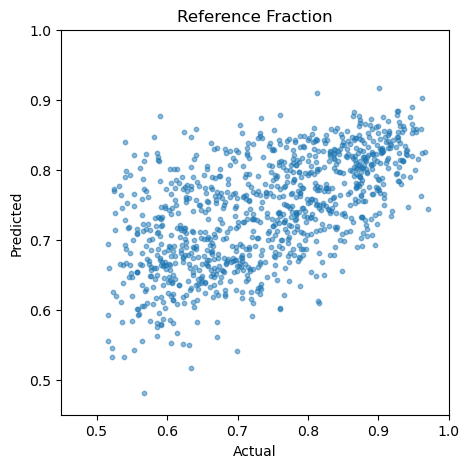

In [23]:
ref_fracs = [i[0]/sum(i) for i in sizes]
plt.figure(figsize=(5,5))
plt.scatter(ref_fracs, p_nn_ref_fracs, alpha=0.5, s=10)
plt.title('Reference Fraction')
plt.xlabel('Actual')
plt.ylabel('Predicted');
plt.ylim([0.45, 1])
plt.xlim([0.45, 1]);
